In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cebra_v2 as cebra2

In [54]:
import importlib
importlib.reload(cebra2.dataset)
importlib.reload(cebra2.solver)
importlib.reload(cebra2.distribution)

<module 'cebra_v2.distribution' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/distribution.py'>

In [109]:
loaded_arrays = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/SYNTHETIC_database/sub-200_states-4_noise-high_synth/dataset.npz')
print(loaded_arrays.files)

['data25', 'dfc25', 'labels25', 'data30', 'dfc30', 'labels30', 'data35', 'dfc35', 'labels35', 'data40', 'dfc40', 'labels40', 'data45', 'dfc45', 'labels45', 'states']


In [110]:
data25 = loaded_arrays['data25']
array = np.mean(data25,axis = 3)[0]
fc_dataset = cebra2.dataset.TensorDataset(array)

In [111]:
num_output = 3
normalize = True
num_neurons = 82

model = cebra2.model.Model(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(
        num_neurons,
        num_output * 30,
    ),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 30),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 10),
    nn.GELU(),
    nn.Linear(int(num_output * 10), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize=normalize,
        )

In [112]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.InfoMSE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.InfoNCE(temperature=kwargs['temperature'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

In [113]:
@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [114]:
array = np.mean(data25,axis = 3)[0]
num_output = 3
normalize = True
num_neurons = 82

model = cebra2.model.Model(
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(
        num_neurons,
        num_output * 30,
    ),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 30),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 10),
    nn.GELU(),
    nn.Linear(int(num_output * 10), num_output),
    num_input=num_neurons,
    num_output=num_output,
    normalize=normalize,
        )

In [115]:
fc_loader = cebra2.dataset.Loader(fc_dataset, num_steps = 10000, batch_size = 1024, time_delta = 15)

In [116]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, learning_rate = 3e-2, model = model)

In [117]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 6.9304, Train accuracy 0.00%
Epoch 1000
Train loss 6.1101, Train accuracy 0.00%
Epoch 2000
Train loss 6.1102, Train accuracy 0.00%


KeyboardInterrupt: 

(-1.0998066842556, 1.0990704476833344, -1.0881083607673645, 1.0899842381477356)

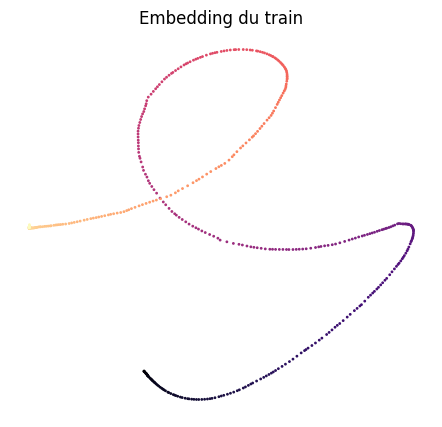

In [118]:
fc_emb = _compute_emissions_single(cebra_fc, fc_dataset.neural)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
ax1.scatter(fc_emb[:,0], fc_emb[:,1], cmap = 'magma', c = np.arange(475), s=1)
ax1.axis('off')

(-1.0984264850616454,
 1.0963136196136474,
 -1.0927744895219802,
 1.0902796179056167)

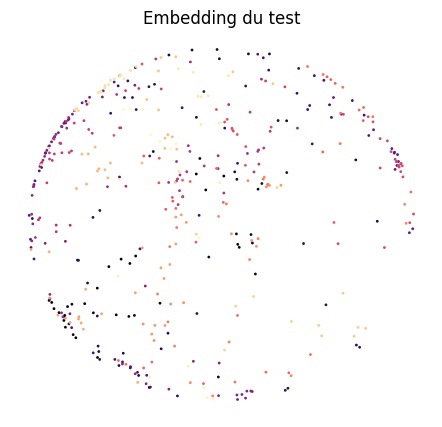

In [106]:
test = np.mean(data25,axis = 3)[4]
fc_test = cebra2.dataset.TensorDataset(test)
fc_emb_test = _compute_emissions_single(cebra_fc, fc_test.neural)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du test')
ax1.scatter(fc_emb_test[:,0], fc_emb_test[:,1], cmap = 'magma', c = np.arange(475), s=1)
ax1.axis('off')